<a href="https://colab.research.google.com/github/EdenNguyenDo/Australia-vehicles-classification/blob/main/fine_tune_florence_2_vehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [22]:
%%capture
!pip install timm flash_attn einops;

In [23]:
%%bash
# Check if the directory already exists and remove it if it does.
if [ -d "Australia-vehicles-classification" ]; then
  rm -rf Australia-vehicles-classification
fi

# Clone the repository.
git clone https://github.com/EdenNguyenDo/Australia-vehicles-classification.git

# Verify the clone was successful.
echo "Cloning complete. Contents of the repository:"
ls Australia-vehicles-classification

Cloning complete. Contents of the repository:
dataset
fine_tune_florence_2_vehicle.ipynb
helpers
index.html
LICENSE
README.md
requirements.txt
segment_applet.py
utils.py


Cloning into 'Australia-vehicles-classification'...


In [24]:
cd Australia-vehicles-classification

/content/Australia-vehicles-classification/Australia-vehicles-classification


Now we import the packages we'll need, including the `utils.py` module from the repository that we just cloned. This file provides misellaneous functionality to make it easier to work with Florence-2.

In [25]:
import copy

from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests

import utils



%matplotlib inline

Next we load the Florence-2 model and processor

In [26]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

And then we set these models as constants for our `utils.py` module so that the functions can utilize them as global constants.

In [27]:
utils.set_model_info(model, processor)

LOAD IMAGES

In [28]:
path = "dataset/train/frame2.png"
image = Image.open(path)
image_rgb = Image.open(path).convert("RGB")

#### Object detection

Object detection automatically detects the salient objects in an image. Florence-2 supports 3 levels of semantic granularity:
1. None (bounding boxes only)
2. Categorical labels
3. Descriptive labels

<OD>


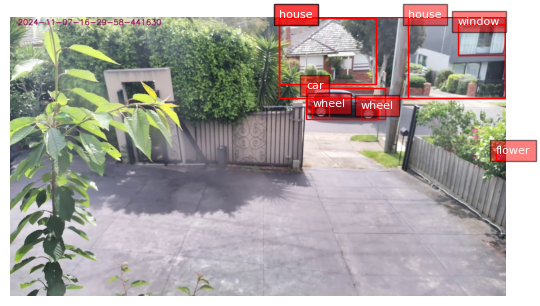

In [29]:
tasks = [#utils.TaskType.REGION_PROPOSAL,
         utils.TaskType.OBJECT_DETECTION
         #utils.TaskType.DENSE_REGION_CAPTION,
         ]

for task in tasks:
  results = utils.run_example(task, image_rgb)
  print(task.value)
  utils.plot_bbox(results[task], image)

# FINE TUNING FLORENCE 2 AND TRAIN ON A CUSTOM DATASET

In [30]:
!pip install -q roboflow git+https://github.com/roboflow/supervision.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [31]:
# @title Imports

import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv

from google.colab import userdata
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

In [46]:
CHECKPOINT = "microsoft/Florence-2-large"
#REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)

In [47]:
# @title Define `DetectionsDataset` class

class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [48]:
# @title Initiate `DetectionsDataset` and `DataLoader` for train and validation subsets

BATCH_SIZE = 6
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    images = [image.convert('RGB') for image in images]
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = "dataset/train/annotation.jsonl",
    image_directory_path = "dataset/train/"
)
val_dataset = DetectionDataset(
    jsonl_file_path = "dataset/valid/annotation.jsonl",
    image_directory_path = "dataset/valid/"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

### Setup LoRA Florence-2 model


LoRA is low-rank decomposition method to reduce the number of trainable parameters which speeds up finetuning large models and uses less memory.

In [49]:
# @title Config Lora
config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 4,133,576 || all params: 826,827,464 || trainable%: 0.4999


In [50]:
torch.cuda.empty_cache()


In [51]:
# @title Run inference with pre-trained Florence-2 model on validation dataset

def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='png')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/png;base64,{image_b64}"


def render_example(image: Image.Image, response):
    # try:
      detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
      image = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
      image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
      # if detections is not None:
      #   utils.plot_bbox(detections, image)
      # except:
      #print('failed to render model response')
      return f"""


      {html.escape(json.dumps(response))}
      """


def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        # Ensure the image is in RGB format and has the correct shape.
        image = image.convert('RGB')  # Convert to RGB format

        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
    #     if answer is not None:
        html_out += render_example(image, answer)
    # print(html_out)
    display(HTML(html_out))

render_inference_results(peft_model, val_dataset, 4)

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [52]:

# @title Define train loop

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    render_inference_results(peft_model, val_loader.dataset, 6)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            render_inference_results(peft_model, val_loader.dataset, 6)

        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

In [53]:
# @title Run train loop

%%time

EPOCHS = 17
LR = 5e-6

train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 1/17: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


Average Training Loss: 7.117645502090454


Validation Epoch 1/17: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Average Validation Loss: 8.47315502166748


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
Training Epoch 2/17: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Average Training Loss: 6.959009170532227


Validation Epoch 2/17: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Average Validation Loss: 8.382186889648438


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 3/17: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


Average Training Loss: 7.4907824993133545


Validation Epoch 3/17: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Average Validation Loss: 8.296518325805664


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 4/17: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


Average Training Loss: 6.654698848724365


Validation Epoch 4/17: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Average Validation Loss: 8.220584869384766


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 5/17: 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


Average Training Loss: 6.91650128364563


Validation Epoch 5/17: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Average Validation Loss: 8.154759407043457


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 6/17: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Average Training Loss: 6.35809588432312


Validation Epoch 6/17: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Average Validation Loss: 8.095776557922363


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 7/17: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Average Training Loss: 6.653280019760132


Validation Epoch 7/17: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Average Validation Loss: 8.04365062713623


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 8/17: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Average Training Loss: 6.620072603225708


Validation Epoch 8/17: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Average Validation Loss: 7.996462345123291


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 9/17: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Average Training Loss: 6.5350563526153564


Validation Epoch 9/17: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Average Validation Loss: 7.954015731811523


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 10/17: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Average Training Loss: 6.625474691390991


Validation Epoch 10/17: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Average Validation Loss: 7.917111396789551


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 11/17: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Average Training Loss: 6.091417074203491


Validation Epoch 11/17: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Average Validation Loss: 7.885855674743652


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 12/17: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Average Training Loss: 7.036599159240723


Validation Epoch 12/17: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Average Validation Loss: 7.859402179718018


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 13/17: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Average Training Loss: 6.412074327468872


Validation Epoch 13/17: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Average Validation Loss: 7.837493419647217


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 14/17: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Average Training Loss: 7.014654874801636


Validation Epoch 14/17: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Average Validation Loss: 7.820193767547607


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 15/17: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Average Training Loss: 6.912168979644775


Validation Epoch 15/17: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Average Validation Loss: 7.8072733879089355


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 16/17: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Average Training Loss: 6.250943183898926


Validation Epoch 16/17: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Average Validation Loss: 7.799057960510254


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Training Epoch 17/17: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Average Training Loss: 6.750555753707886


Validation Epoch 17/17: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Average Validation Loss: 7.7955322265625


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


CPU times: user 2min 49s, sys: 13.3 s, total: 3min 2s
Wall time: 3min


### Save the model

In [87]:
peft_model.save_pretrained("/content/Australia-vehicles-classification/Australia-vehicles-classification/saved_model/florence2-lora")
processor.save_pretrained("/content/Australia-vehicles-classification/Australia-vehicles-classification/saved_model/florence2-lora")


[]

In [88]:
!ls -la "/content/Australia-vehicles-classification/Australia-vehicles-classification/saved_model/florence2-lora"


total 21476
drwxr-xr-x 2 root root     4096 Nov 15 00:25 .
drwxr-xr-x 3 root root     4096 Nov 15 00:25 ..
-rw-r--r-- 1 root root      744 Nov 15 00:25 adapter_config.json
-rw-r--r-- 1 root root 16582384 Nov 15 00:25 adapter_model.safetensors
-rw-r--r-- 1 root root    22410 Nov 15 00:25 added_tokens.json
-rw-r--r-- 1 root root   456318 Nov 15 00:25 merges.txt
-rw-r--r-- 1 root root      631 Nov 15 00:25 preprocessor_config.json
-rw-r--r-- 1 root root     5100 Nov 15 00:25 README.md
-rw-r--r-- 1 root root   146627 Nov 15 00:25 special_tokens_map.json
-rw-r--r-- 1 root root   197659 Nov 15 00:25 tokenizer_config.json
-rw-r--r-- 1 root root  3747961 Nov 15 00:25 tokenizer.json
-rw-r--r-- 1 root root   798293 Nov 15 00:25 vocab.json


In [80]:

# Running inference
!pip install inference


In [91]:
import os
from PIL import Image
import json
from google.colab import userdata
import roboflow

rf = Roboflow(api_key=userdata.get('ROBOFLOW_KEY'))
project = rf.workspace("first-project-xpdzs").project("vehicle-detect-tksbg")
version = project.version(3)

version.deploy(model_type="florence-2-large", model_path="/content/Australia-vehicles-classification/Australia-vehicles-classification/saved_model/florence2-lora")




loading Roboflow workspace...
loading Roboflow project...
Model files found in /content/Australia-vehicles-classification/Australia-vehicles-classification/saved_model/florence2-lora: ['tokenizer.json', 'special_tokens_map.json', 'adapter_model.safetensors', 'merges.txt', 'vocab.json', 'adapter_config.json', 'tokenizer_config.json', 'README.md', 'roboflow_deploy.tar', 'added_tokens.json', 'preprocessor_config.json']
Found .safetensors file in model path. Deploying PyTorch florence-2-large model.
Zipping files for deploy: ['tokenizer.json', 'special_tokens_map.json', 'adapter_model.safetensors', 'merges.txt', 'vocab.json', 'adapter_config.json', 'tokenizer_config.json', 'README.md', 'roboflow_deploy.tar', 'added_tokens.json', 'preprocessor_config.json']
Uploading to Roboflow... May take several minutes.
View the status of your deployment at: https://app.roboflow.com/first-project-xpdzs/vehicle-detect-tksbg/3
Share your model with the world at: https://universe.roboflow.com/first-project

In [93]:
from inference import get_model

lora_model = get_model("vehicle-detect-tksbg/3", api_key=userdata.get('ROBOFLOW_KEY'))

image = Image.open("Australia-vehicles-classification/dataset/test/frame7.png")
response = lora_model.infer(image)
print(response)

RoboflowAPINotNotFoundError: Could not find requested Roboflow resource. Check that the provided dataset and version are correct, and check that the provided Roboflow API key has the correct permissions.

In [64]:
import pdb